In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import holidays
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 가스 공급 예측 모델

## 목표 -> 데이터확인-> 모델설계-> 모델개발-> 결과발표


### 목표 :

### 한국가스공사의 시간단위 공급량 내부데이터와 기상정보 및 가스외 발전량 등 외부데이터를 ### 포함한 데이터셋을 구축하여 90일 한도 일간 공급량을 예측하는 인공지능 모델 개발
### ↓
### 데이터셋을 구축하고 일단위로 예측값과 실제값을 비교한다.

## 데이터 확인
### 데이터 확인+전처리+데이터셋 구축 과정 설명

#### 추가한 데이터:온도데이터/습도데이터/휴일데이터
##### 왜추가했는가?
##### 도시가스공급에 가장 많은 영향은 추위 아닐까?-온도
##### 이상열, & 정희용. (2015). "산업용 도시가스 수요변화 요인분석". 에너지경제연구원 수시연구보고서) - 습도
##### (김윤배 .(2013)"도시가스 일일수요의 단기예측." 대한산업공학회지 )** - 휴일

In [13]:
#result
#세션 초기화 및 런올 하면 오류발생

,날짜,공급량(톤),월,평균기온,평균습도,휴일_근무,휴일_휴일
0,2013-01-01,315365.534,1,-0.90,62.21,False,True
1,2013-01-02,388233.480,1,-0.90,62.21,True,False
2,2013-01-03,429572.504,1,-0.90,62.21,True,False
3,2013-01-04,423508.264,1,-0.90,62.21,True,False
4,2013-01-05,386400.016,1,-0.90,62.21,True,False
...,...,...,...,...,...,...,...
2187,2018-12-28,408375.917,12,1.11,63.93,True,False
2188,2018-12-29,372490.024,12,1.11,63.93,True,False
2189,2018-12-30,354085.368,12,1.11,63.93,True,False
2190,2018-12-31,367021.378,12,1.11,63.93,True,False


In [3]:
df = pd.read_csv("한국가스공사_시간별 공급량_20181231.csv",encoding = "cp949")
df.describe()
#구분이되어있어서 그렇지이상치,결측치는없음

,시간,공급량(톤)
count,368088.000000,368088.000000
mean,12.500000,948.100037
std,6.922196,927.211578
min,1.000000,1.378000
25%,6.750000,221.973000
50%,12.500000,637.014000
75%,18.250000,1398.919000
max,24.000000,11593.617000


In [4]:
df = pd.read_csv("한국가스공사_시간별 공급량_20181231.csv",encoding = "cp949")
#df를 불러오니까 데이터타입이 이상하고 datetime도 아니길래 다 바꿔줬다. 아래가 그 과정
df["연월일"]=pd.to_datetime(df["연월일"])
df['시간'] = pd.to_timedelta(df['시간'], unit='h')
df["날짜"]=df["연월일"]+df["시간"]
df = df.drop(columns = ["연월일","시간"])
column_to_move = "날짜"


# 선택한 열의 위치를 맨 앞으로 이동
df.insert(0, column_to_move, df.pop(column_to_move))
df

,날짜,구분,공급량(톤)
0,2013-01-01 01:00:00,A,2497.129
1,2013-01-01 02:00:00,A,2363.265
2,2013-01-01 03:00:00,A,2258.505
3,2013-01-01 04:00:00,A,2243.969
4,2013-01-01 05:00:00,A,2344.105
...,...,...,...
368083,2018-12-31 20:00:00,H,681.033
368084,2018-12-31 21:00:00,H,669.961
368085,2018-12-31 22:00:00,H,657.941
368086,2018-12-31 23:00:00,H,610.953


In [5]:
평년기온 = [-0.9, 1.4, 6.32, 12.24, 17.64, 21.76, 24.85, 25.56, 20.9, 14.64, 7.87, 1.11]
평년습도 = [62.21, 60.58, 60.69, 60.9, 65.78, 73.22, 80.49, 79.35, 76.52, 70.95, 67.44, 63.93]
# 월별 평균기온을 알면 월별로 얼마나추운지 알수있다
# https://data.kma.go.kr/climate/average30Years/selectAverage30YearsList.do?pgmNo=113
# 여기서 1991년~2020년 지역별월평균 다구할수있다.->지역구분을 두지않고 전부더해서 평균(한국월별평균온도)
# 거기에 전부 평균값 떄려넣으면 될듯

#하루마다의 습도나 온도를 구하기는 매우어려움(시간이없음) 그래서 걍 1달치로 ㅇㅇ

In [6]:
#날짜에서 00:00:00은 항상 애매하다
#00:00:01로 바꿔버리자
df['날짜'] += pd.to_timedelta(1, unit='S')
#구분은 의미가 없다. 그냥 구분을 없애고 날짜별로 7개씩 중복이 있을테니 
#공급사별로 어떤특징이 있는지 모르는데 구분지어봤자 큰의미가 있나?
#그거 전부합쳐버리자 어차피 중요한건 일별 공급량이다.

df = df.groupby("날짜").sum()
df.reset_index(inplace = True)
#월변수 하나 넣자 평균기온,평균습도 때문에 넣는거임->나중에 맵핑하자
df['월'] = df['날짜'].dt.month
#월에 따른 평균기온을 넣어주자
#월에 따른 평균습도를 넣어주
df['평균기온'] = df['월'].map(dict(zip(range(1, 13), 평년기온)))
df['평균습도'] = df['월'].map(dict(zip(range(1, 13), 평년습도)))

In [7]:

#우리의 목표는 일단위 예측하는거임
#그니까 그냥 시간도 빼버리고 합쳐버리자
df['날짜_날짜'] = df['날짜'].dt.date
df=df.drop(columns = ["날짜"])
df.rename(columns = {"날짜_날짜":"날짜"},inplace = True)
#날짜(하루단위)로 그룹화 하고 공급량을 다 더해줬다.
result = df.groupby("날짜", as_index=False).agg({'공급량(톤)': 'sum', '월': 'first', '평균기온': 'first', '평균습도': 'first'})
# #datetime 으로바꿔
result["날짜"]=pd.to_datetime(result["날짜"])
# #공휴일이면 공휴일이라고 써놔
import holidays
holidays = holidays.KR()
result['공휴일'] = result['날짜'].apply(lambda x: '휴일' if x in holidays else '근무')
#공휴일 원핫인코딩
one_hot_encoded = pd.get_dummies(result['공휴일'], prefix='휴일')

# 기존 데이터프레임과 원-핫 인코딩된 열들을 합치기
result = pd.concat([result, one_hot_encoded], axis=1)

# "공휴일" 열 삭제
result.drop(columns=['공휴일'], inplace=True)
result

,날짜,공급량(톤),월,평균기온,평균습도,휴일_근무,휴일_휴일
0,2013-01-01,315365.534,1,-0.90,62.21,False,True
1,2013-01-02,388233.480,1,-0.90,62.21,True,False
2,2013-01-03,429572.504,1,-0.90,62.21,True,False
3,2013-01-04,423508.264,1,-0.90,62.21,True,False
4,2013-01-05,386400.016,1,-0.90,62.21,True,False
...,...,...,...,...,...,...,...
2187,2018-12-28,408375.917,12,1.11,63.93,True,False
2188,2018-12-29,372490.024,12,1.11,63.93,True,False
2189,2018-12-30,354085.368,12,1.11,63.93,True,False
2190,2018-12-31,367021.378,12,1.11,63.93,True,False


## 모델 설계/개발

### 시계열 자료+ 그것을 예측하는 것이 목적이기에 LSTM선정
### 일일 가스공급량을 예측하는 것 = y
### 나머지 변수들을 다 넣는것이 가장 성능이 좋기에 =x

### window size는 대회목표에 한도 90일이라는 말이 있기에 90으로 선정
### 최적화는 sgd,adam,adagrad중 최고성능 선정
### 활성화는 tanh,relu중 최고성능 선정
### node갯수는 2의제곱에서 서서히 떨어지는 방법(딥러닝에서 자주사용/감소하는게 lstm의장점살림)
### epoch는 10,20,50,100 다양한 방법으로 했는데 20~25에서 거의 비슷한 성능으로 수렴->23

In [8]:
from keras.layers import LSTM, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 데이터 준비
dfx = result[["평균기온","평균습도","휴일_근무","휴일_휴일","공급량(톤)"]]
for col in dfx.columns:
    scaler = MinMaxScaler()
    dfx[col] = scaler.fit_transform(dfx[[col]])
dfy = dfx[["공급량(톤)"]]
dfx = dfx[["공급량(톤)","평균기온","평균습도","휴일_근무","휴일_휴일"]]

x = dfx.values.tolist()
y = dfy.values.tolist()

window_size = 90
data_x, data_y = [], []
for i in range(len(y) - window_size):
    try:
        _x = x[i:i+window_size]
        _y = y[i+window_size]
        data_x.append(_x)
        data_y.append(_y)
    except IndexError:
        # 인덱스 오류가 발생한 경우 무시해
        continue

train_size = int(len(data_y) * 0.8)
train_x = np.array(data_x[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_x = np.array(data_x[train_size : len(data_x)])
test_y = np.array(data_y[train_size : len(data_y)])


print('훈련 데이터의 크기 :', train_x.shape, train_y.shape)
print('테스트 데이터의 크기 :', test_x.shape, test_y.shape)


# 모델 정의
model = Sequential()
model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(90,5)))
model.add(LSTM(units=128, activation='relu', return_sequences=True))
model.add(LSTM(units=64, activation='relu',return_sequences=True))
model.add(LSTM(units=32, activation='relu'))
model.add(Dense(1, activation='linear'))

# 모델 컴파일
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# 모델 학습
model.fit(train_x, train_y, epochs=23, batch_size=64) # 23이 최적

# 모델 평가
loss = model.evaluate(test_x, test_y)
print("테스트 데이터 손실:", loss)

훈련 데이터의 크기 : (1681, 90, 5) (1681, 1)
테스트 데이터의 크기 : (421, 90, 5) (421, 1)



C:\Users\chunjae\AppData\Local\Temp\ipykernel_19076\3554620961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[col] = scaler.fit_transform(dfx[[col]])
C:\Users\chunjae\AppData\Local\Temp\ipykernel_19076\3554620961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[col] = scaler.fit_transform(dfx[[col]])
C:\Users\chunjae\AppData\Local\Temp\ipykernel_19076\3554620961.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

Epoch 1/23

27/27 [==============================] - 9s 276ms/step - loss: 0.1034
Epoch 2/23
27/27 [==============================] - 8s 303ms/step - loss: 0.0513
Epoch 3/23
27/27 [==============================] - 8s 302ms/step - loss: 0.0110
Epoch 4/23
27/27 [==============================] - 8s 307ms/step - loss: 0.0069
Epoch 5/23
27/27 [==============================] - 8s 305ms/step - loss: 0.0045
Epoch 6/23
27/27 [==============================] - 8s 306ms/step - loss: 0.0033
Epoch 7/23
27/27 [==============================] - 8s 307ms/step - loss: 0.0029
Epoch 8/23
27/27 [==============================] - 8s 306ms/step - loss: 0.0028
Epoch 9/23
27/27 [==============================] - 8s 304ms/step - loss: 0.0027
Epoch 10/23
27/27 [==============================] - 8s 307ms/step - loss: 0.0029
Epoch 11/23
27/27 [==============================] - 8s 308ms/step - loss: 0.0028
Epoch 12/23
27/27 [==============================] - 8s 308ms/step - loss: 0.0025
Epoch 13/23
27/27 [=====

## 결과 시각화

### 어느정도 경향성은 맞으나 정확도가 떨어짐

14/14 [==============================] - 2s 77ms/step


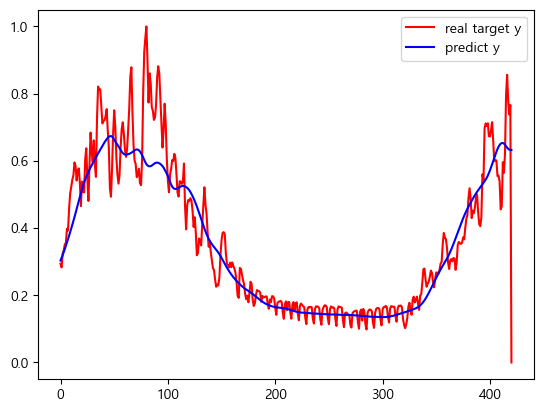

In [9]:
pred_y = model.predict(test_x)

plt.figure()
plt.plot(test_y, color='red', label='real target y')
plt.plot(pred_y, color='blue', label='predict y')
plt.legend()
plt.show()

14/14 [==============================] - 1s 77ms/step


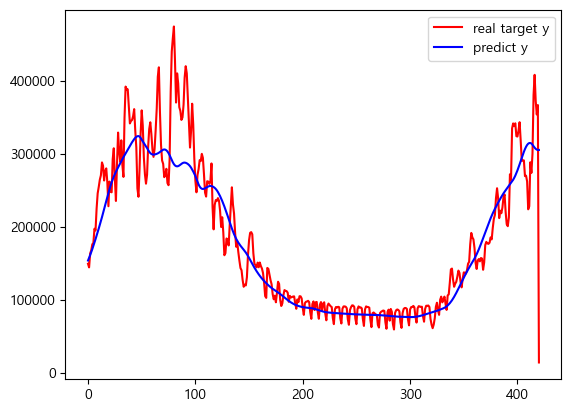

In [10]:
##디코딩 시각화(똑같기는함)
pred_y = model.predict(test_x)

plt.figure()
plt.plot(scaler.inverse_transform(test_y), color='red', label='real target y')
plt.plot(scaler.inverse_transform(pred_y), color='blue', label='predict y')
plt.legend()
plt.show()

## 보완점

## * 데이터의 부족(칼럼)
## * 상관관계가 높은 데이터
### (중요하다고 생각되는 칼럼이 전부 상관관계가 높음->제외말고 다른방법을 모색->pca했으나 심각한 성능저하 발생->이유는 잘..)
## *더 좋은 모델/파라미터가 있지는 않을까
## * 구분이라는 열을 제외하지 않고 각각 했으면?
## * 도시가스의 종류가 사실 상당히 많던데 그것을 반영했다면?

# 후속연구에 위의 내용들을 반영하면 더 높은 성능 기대